In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [3]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    num_values = len(activity1.values[0])
    
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2, "retained":3}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

 <br></br><br></br><br></br>

In [4]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [5]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [6]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(100000, 8, 38)
(100000, 4)


<br></br><br></br><br></br>

# Model

In [7]:
class RNN() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    def build(self, batch_size, length, dim, is_embedding, emb_width, num_unit, is_fc, fc_num_unit, fc_activation, cost_function, output_dim) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            self.batch_size = batch_size
            self.length = length
            self.dim = dim
            self.is_embedding = is_embedding
            self.emb_width = emb_width
            self.num_unit = num_unit
            self.is_fc = is_fc
            self.fc_num_unit = fc_num_unit
            self.fc_activation = fc_activation
            self.output_dim = output_dim
            
            self.X = tf.placeholder(tf.float32, [self.batch_size, self.length, self.dim])
            self.Y = tf.placeholder(tf.float32, [self.batch_size, self.output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            #############
            
            
            ## Embedding ##
            if self.is_embedding :
                W_emb = tf.Variable(tf.random_normal([self.width, self.emb_width]))
                self.X = tf.concat(self.X, tf.matmul(self.X, W_emb), axis=2)
            ###############
            
            
            ## RNN ##
            f_cell1 = tf.nn.rnn_cell.BasicLSTMCell(self.num_unit)
            f_cell2 = tf.nn.rnn_cell.BasicLSTMCell(self.num_unit)
            f_multi_cell = tf.nn.rnn_cell.MultiRNNCell([f_cell1, f_cell2])
            
            f_output, f_state = tf.nn.dynamic_rnn(f_multi_cell, self.X, dtype=tf.float32)
            rnn_result = tf.transpose(f_output,[1,0,2])[-1]
            #########
    
            
            ## Classifier ##
            if is_fc : 
                dense= tf.layers.dense(rnn_result, self.fc_num_unit)
                norm = tf.contrib.layers.layer_norm(dense)
                relu = tf.nn.relu(norm)
                self.logit = tf.layers.dense(norm, 4)
            else :
                self.logit = tf.layers.dense(rnn_result, 4)
                
            self.softmax = tf.nn.softmax(self.logit)
            ################
            
            
            ## Learning ##
            if cost_function == "f1" :
                self.numerator = tf.reduce_sum(self.softmax*self.Y)
                self.denominator = tf.reduce_sum(self.softmax*self.Y + self.Y)
                self.cost = -2 * self.numerator / self.denominator
                
            else :
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y))

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [8]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [9]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 80
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [10]:
idx = 0
is_pass = False
model_lst = []

for is_embedding in [False, True] :
    for emb_width in [64,128] :
        if not is_pass :
            is_pass = True
            continue
            
        for num_unit in [128, 256, 512] :
            for is_fc in [False, True] :
                for cost in ["accuracy"] :
                    print(idx) 
                    sess = tf.Session()
                    model = RNN(sess, "model{}".format(idx))
                    model.build(500, 8, 38, False, emb_width, num_unit, is_fc, 128, tf.nn.relu, cost, 4)
                    sess.run(tf.global_variables_initializer())

                    model_lst.append(model)
                    idx +=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Ready!


In [11]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 20 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  0
-- train 0.77106(66.1%), valid0.76944(66.3%)
-- train 0.87301(61.8%), valid0.86543(62.1%)
-- train 0.87919(62.1%), valid0.87595(62.2%)
-- train 1.06975(52.3%), valid1.06669(52.6%)
-- train 1.17069(45.9%), valid1.16354(46.2%)
-- train 1.33360(39.6%), valid1.33400(39.6%)
-- train 0.76921(66.4%), valid0.76704(66.3%)
-- train 0.95943(58.2%), valid0.95203(58.7%)
-- train 0.77762(65.8%), valid0.78049(65.8%)
-- train 1.32504(30.2%), valid1.32250(30.4%)
-- train 0.88935(61.9%), valid0.88738(62.1%)
-- train 1.38378(25.0%), valid1.38382(25.0%)
-- train 0.77295(66.2%), valid0.77430(66.2%)
-- train 1.01246(53.4%), valid1.00608(53.9%)
-- train 0.84388(62.7%), valid0.83854(63.1%)
-- train 1.09478(52.5%), valid1.08858(53.1%)
-- train 0.85765(61.8%), valid0.85570(62.0%)
-- train 1.21602(38.9%), valid1.21594(38.8%)
Accur

Accuracy: 0.673700000346
Accuracy: 0.595249997079
Accuracy: 0.44449999854
Accuracy: 0.692700004578
Accuracy: 0.683399999142
Accuracy: 0.691649998724
Accuracy: 0.558750005066
Accuracy: 0.676400001347
Accuracy: 0.564250005782
Accuracy: 0.691099996865
Accuracy: 0.663949997723
Accuracy: 0.680200001597
Accuracy: 0.683499999344
Accuracy: 0.685099995136
Accuracy: 0.581450001895
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  6
-- train 0.67098(70.4%), valid0.70416(69.0%)
-- train 0.69781(69.2%), valid0.71228(68.6%)
-- train 0.70121(69.0%), valid0.72252(68.2%)
-- train 0.74869(67.2%), valid0.75611(67.2%)
-- train 0.83384(63.5%), valid0.83283(63.8%)
-- train 1.14221(45.9%), valid1.14297(45.9%)
-- train 0.67550(69.9%), valid0.70449(68.9%)
-- train 0.68598(69.6%), valid0.70554(68.9%)
-- train 0.67321(70.1%), valid0.70261(69.2%)
-- train 0.88827(62.2%), valid0.88681(62.4%)
-- train

-- train 0.60294(72.9%), valid0.69325(69.8%)
-- train 0.67975(69.8%), valid0.70977(68.9%)
-- train 0.63257(71.6%), valid0.68853(69.7%)
-- train 0.67013(70.4%), valid0.69925(69.4%)
-- train 0.63426(71.5%), valid0.68695(70.1%)
-- train 0.86790(61.9%), valid0.87545(61.9%)
Accuracy: 0.705449992418
Accuracy: 0.694350001216
Accuracy: 0.696149998903
Accuracy: 0.686050000787
Accuracy: 0.663199996948
Accuracy: 0.608949999511
Accuracy: 0.699399995804
Accuracy: 0.697699998319
Accuracy: 0.699899996817
Accuracy: 0.672449997067
Accuracy: 0.691049997509
Accuracy: 0.603699998558
Accuracy: 0.698149995506
Accuracy: 0.688549999893
Accuracy: 0.697349996865
Accuracy: 0.693799997866
Accuracy: 0.700900003314
Accuracy: 0.618650004268
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  12
-- train 0.59647(73.1%), valid0.68909(70.5%)
-- train 0.65015(70.7%), valid0.69514(69.3%)
-- train 0.62430(71.7

-- train 0.85591(63.1%), valid0.86226(63.0%)
-- train 0.57085(74.2%), valid0.73346(69.9%)
-- train 0.62183(72.0%), valid0.71089(69.7%)
-- train 0.58366(73.8%), valid0.70272(69.9%)
-- train 0.68828(69.2%), valid0.71219(68.4%)
-- train 0.64765(71.2%), valid0.70195(69.5%)
-- train 0.83330(64.1%), valid0.83564(64.2%)
-- train 0.56534(74.4%), valid0.71428(69.9%)
-- train 0.65622(70.7%), valid0.70788(69.3%)
-- train 0.60640(72.8%), valid0.69772(70.3%)
-- train 0.64334(71.5%), valid0.69159(70.0%)
-- train 0.60054(73.0%), valid0.70228(70.2%)
-- train 0.83589(63.4%), valid0.84835(63.2%)
Accuracy: 0.703600001335
Accuracy: 0.695600000024
Accuracy: 0.697199998796
Accuracy: 0.68465000242
Accuracy: 0.667299999297
Accuracy: 0.630000001192
Accuracy: 0.698999999464
Accuracy: 0.69714999944
Accuracy: 0.69904999882
Accuracy: 0.68409999311
Accuracy: 0.695100000501
Accuracy: 0.641999998689
Accuracy: 0.698899994791
Accuracy: 0.693399997056
Accuracy: 0.702599996328
Accuracy: 0.699849998951
Accuracy: 0.7015999

KeyboardInterrupt: 

 <br></br><br></br><br></br> 

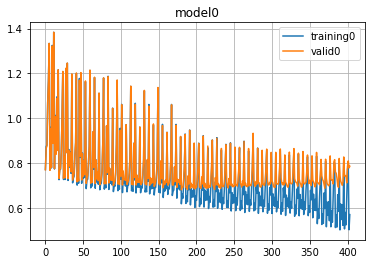

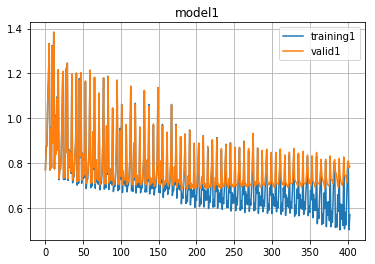

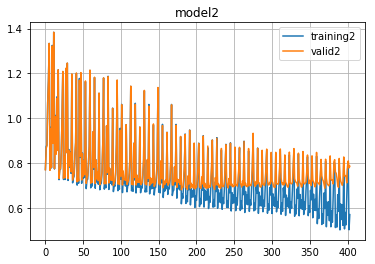

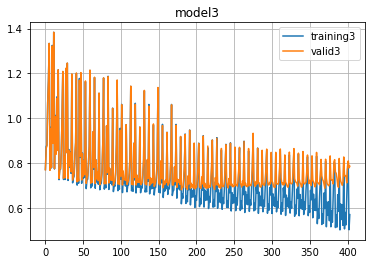

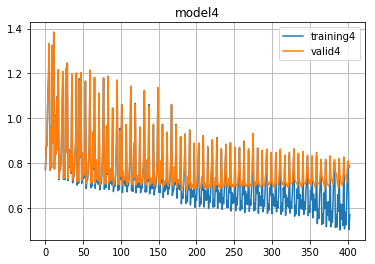

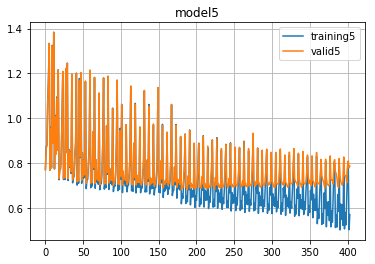

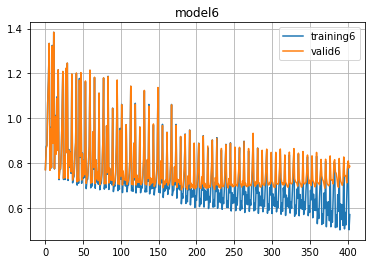

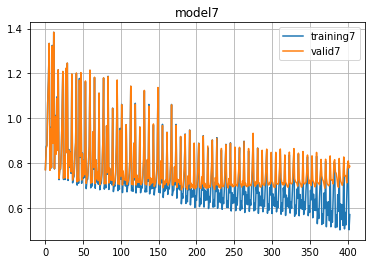

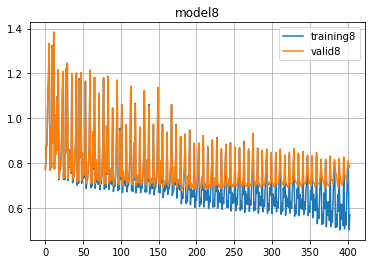

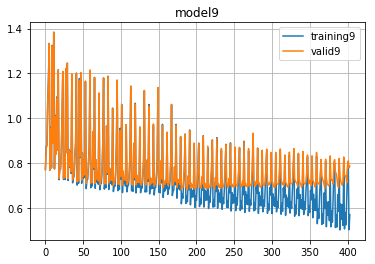

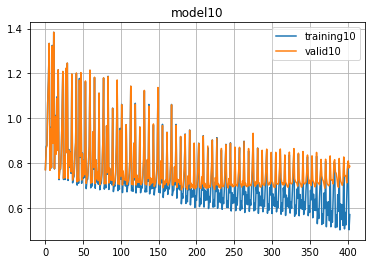

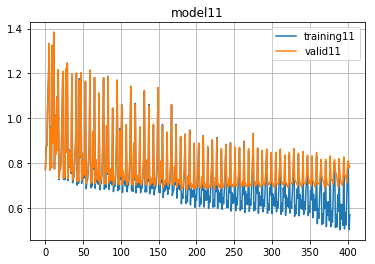

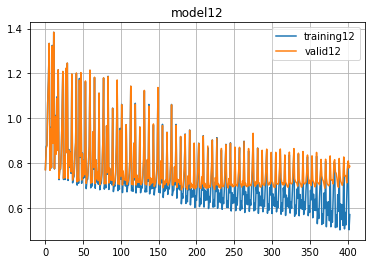

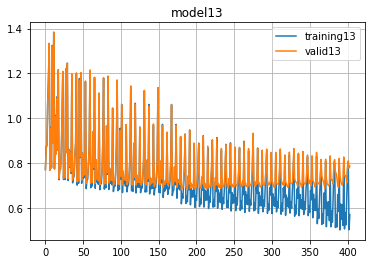

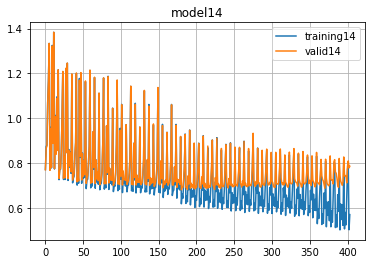

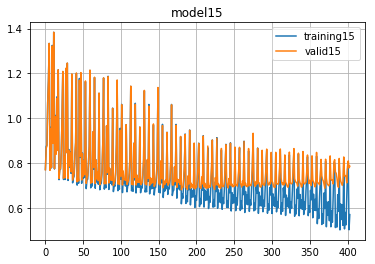

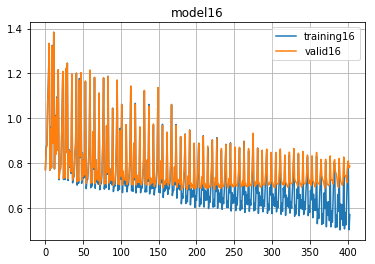

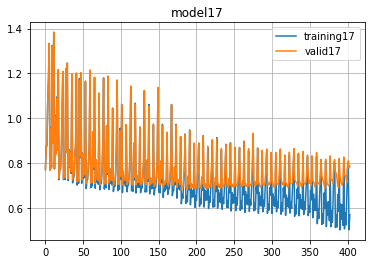

In [12]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

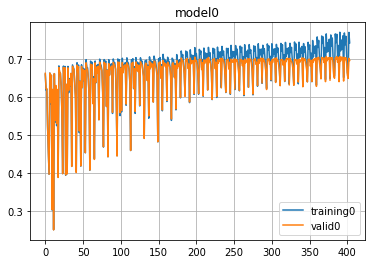

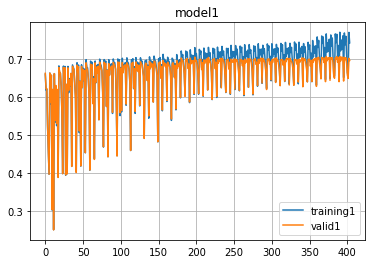

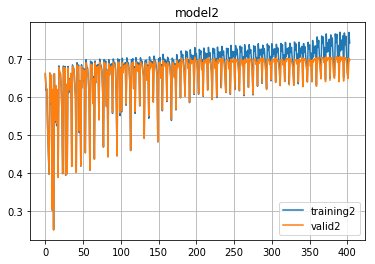

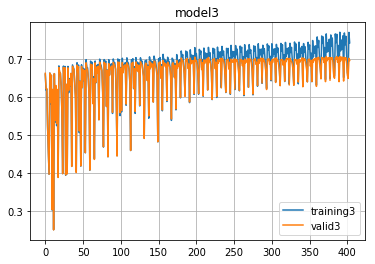

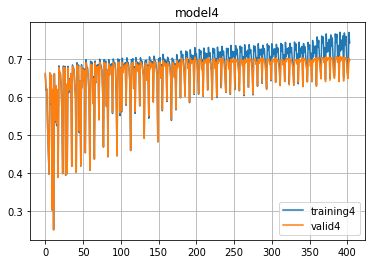

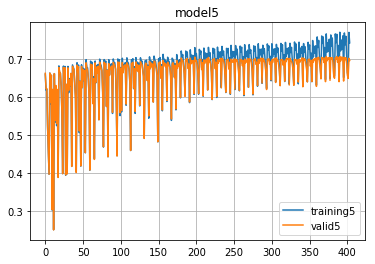

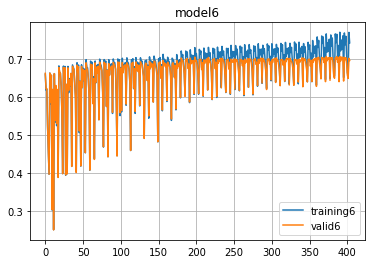

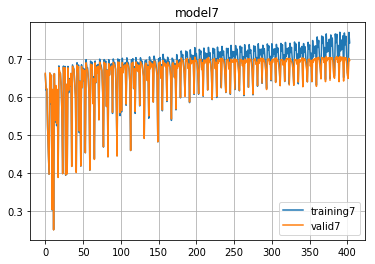

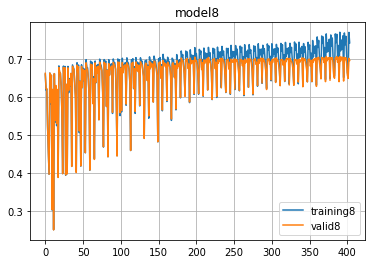

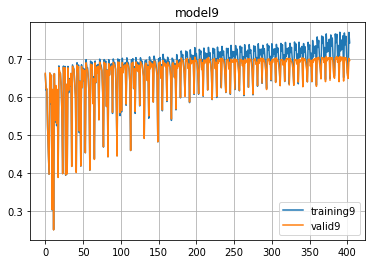

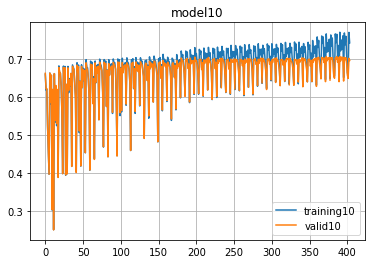

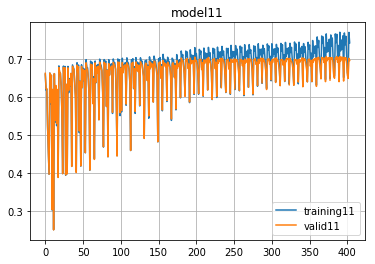

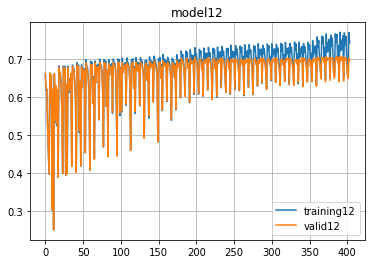

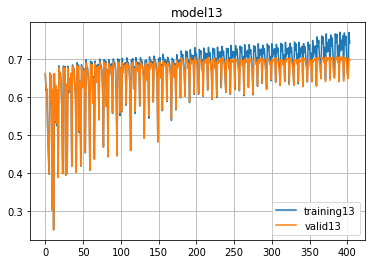

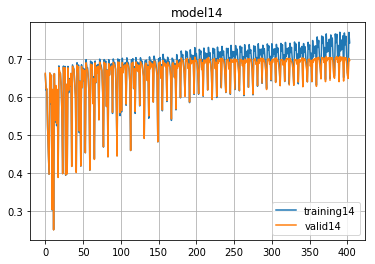

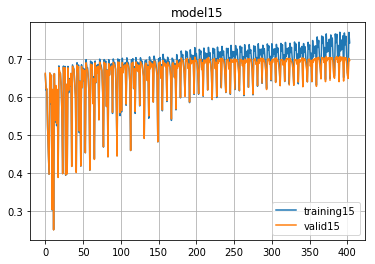

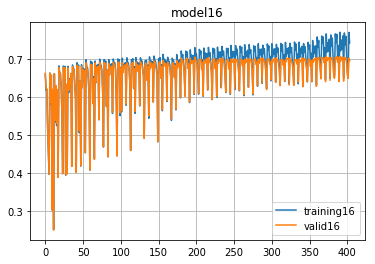

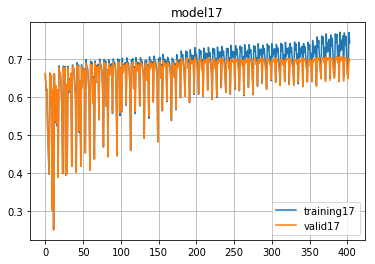

In [13]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

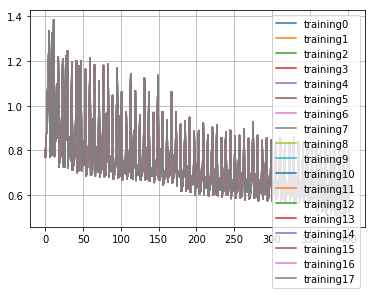

In [14]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

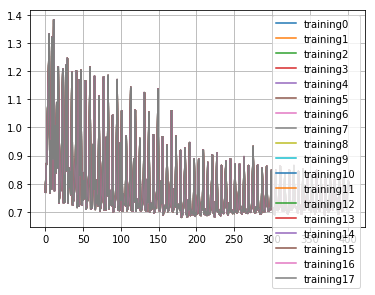

In [15]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

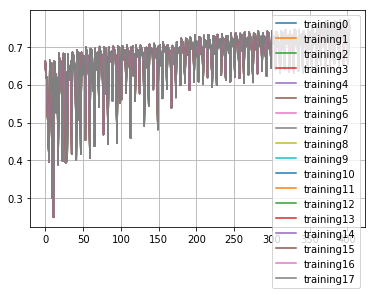

In [16]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

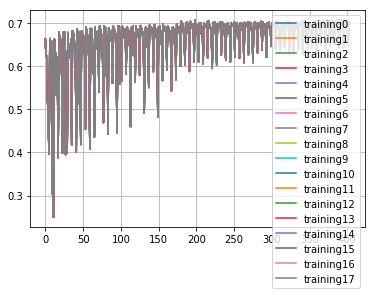

In [17]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

 <br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_default_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [19]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    num_values = len(activity1.values[0])
    
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)

    total_lst = activity
    return total_lst, label

In [20]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [21]:
print(test_data.shape)

(40000, 8, 38)


<br></br><br></br><br></br> 

# Predict

In [23]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

week: 143, month: 75, 2month: 163, retained: 119
week: 135, month: 71, 2month: 160, retained: 134
week: 139, month: 76, 2month: 156, retained: 129
week: 140, month: 52, 2month: 162, retained: 146
week: 133, month: 67, 2month: 158, retained: 142
week: 159, month: 84, 2month: 123, retained: 134
week: 137, month: 83, 2month: 163, retained: 117
week: 135, month: 78, 2month: 153, retained: 134
week: 138, month: 77, 2month: 160, retained: 125
week: 148, month: 56, 2month: 157, retained: 139
week: 146, month: 65, 2month: 153, retained: 136
week: 149, month: 38, 2month: 170, retained: 143
week: 138, month: 78, 2month: 159, retained: 125
week: 137, month: 68, 2month: 158, retained: 137
week: 133, month: 86, 2month: 154, retained: 127
week: 133, month: 71, 2month: 159, retained: 137
week: 133, month: 86, 2month: 159, retained: 122
week: 171, month: 56, 2month: 156, retained: 117


In [ ]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T

In [ ]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()